
# Introduction

In this Notebook, I apply the LSTM classification architecture from this paper: https://arxiv.org/pdf/1709.05206v1.pdf to the infant cry classification problem. Much of the Code is adapted from the authors' github, which is linked below.
The other notebooks, as well as the thesis can be found at https://github.com/fridowicke/infant_cries

# Imports

In [ ]:
!pip install tensorflow==1.13.1
!pip install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Standard Imports
import tensorflow as tf
import numpy as np
from google.colab import drive
import json

from tensorflow import keras
#from tensorflow.keras import layers, losses
#from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
#tf.config.run_functions_eagerly(True)

#Imports for the LSTM implementation
import os
from keras import backend as K
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from keras.layers import Input, Dense, LSTM, CuDNNLSTM, concatenate, Activation, GRU, SimpleRNN
from keras.models import Model

#Clone the Repo
import sys
!git clone https://github.com/houshd/LSTM-FCN
sys.path.insert(0,'/content/LSTM-FCN')
from utils.layer_utils import AttentionLSTM

!pip install wandb
import wandb

fatal: destination path 'LSTM-FCN' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
wandb.login()

wandb: Currently logged in as: frido. Use `wandb login --relogin` to force relogin


True

# Loading the Data

## Mount the Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Save / Load Processed Data

In [ ]:
#Helper function
def load(filename):
    with open(filename) as data:
        x = json.load(data)
    return np.array(x)

#We use json to save the spectrograms and f0s of the produced data in order to avoid computing them every time we use the notebook.
#Helper functions
def save(data, filename):
    if type(data) is np.ndarray:
      data = data.tolist()
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False)

In [ ]:
#Load the f0s

fs_train    = load("/content/drive/My Drive/infant_cries/data_js_final/fs_train.json")
fs_dev_ger  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_dev_ger.json")
fs_dev_jap  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_dev_jap.json")
fs_test_ger  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_test_ger.json")
fs_test_jap  = load("/content/drive/My Drive/infant_cries/data_js_final/fs_test_jap.json")
fs_eval     = (load("/content/drive/My Drive/infant_cries/data_js_final/fs_eval.json"))
y_train      = load("/content/drive/My Drive/infant_cries/data_js_final/y_train.json")

## Create Datasets

In [ ]:
#Reshape the f_s
input_shape = fs_train.shape[1:]
fs_train = fs_train.reshape((fs_train.shape[0], 1, fs_train.shape[1],))
fs_dev_ger = fs_dev_ger.reshape((fs_dev_ger.shape[0], 1, fs_dev_ger.shape[1]))
fs_dev_jap = fs_dev_jap.reshape((fs_dev_jap.shape[0], 1, fs_dev_jap.shape[1]))
fs_test_ger = fs_test_ger.reshape((fs_test_ger.shape[0], 1, fs_test_ger.shape[1]))
fs_test_jap = fs_test_jap.reshape((fs_test_jap.shape[0], 1, fs_test_jap.shape[1]))
fs_eval = fs_eval.reshape((fs_eval.shape[0], 1, fs_eval.shape[1]))



#Compute the number of samples
n_dev_ger = fs_dev_ger.shape[0]
n_dev_jap = fs_dev_jap.shape[0]
n_test_ger = fs_test_ger.shape[0]
n_test_jap = fs_test_jap.shape[0]
n_eval = fs_eval.shape[0]

#Create y_s for dev, test and eval
y_dev_ger = np.zeros(n_dev_ger)
y_dev_jap = np.ones(n_dev_jap)
y_test_ger = np.zeros(n_test_ger)
y_test_jap = np.ones(n_test_jap)
y_eval    = np.zeros(n_eval)

# LSTM Paper

Paper Link: https://arxiv.org/pdf/1709.05206v1.pdf
GitHub Link: https://github.com/houshd/LSTM-FCN

In [ ]:
def build_lstm(num_cells=8, length=input_shape[0], num_classes=2):

    ip = Input(shape=(1, length))

    x = LSTM(num_cells)(ip)
    x = Dropout(0.8)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    x = concatenate([x, y])

    out = Dense(num_classes, activation='softmax')(x)

    model = Model(ip, out)
    return model

# WandB Sweep

In [ ]:
sweep_config_lstm = {
    'method' : 'grid',
    'metric' : {'name': 'accuracy_dev',
                'goal': 'maximize'},
    'parameters': {
        'num_cells': {
            'values': [4, 8, 16]
            },
        'epochs': {
            'values': [5*i for i in range(1,20)]
        }
    },
     
}

In [ ]:
def train(config=None):

    # Initialize a new wandb run
    with wandb.init(config=config):

        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        #Create and Compile the LSTM
        lstm = build_lstm(config.num_cells)
        lstm.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        #Train and Evaluate the LSTM
        lstm.fit(fs_train, y_train, epochs = config.epochs)
        _, acc_dev_ger = lstm.evaluate(fs_dev_ger, y_dev_ger)
        _, acc_dev_jap = lstm.evaluate(fs_dev_jap, y_dev_jap)
        _, acc_test_ger = lstm.evaluate(fs_test_ger, y_test_ger)
        _, acc_test_jap = lstm.evaluate(fs_test_jap, y_test_jap)
        _, acc_eval = lstm.evaluate(fs_eval, y_eval)
        acc_dev  = (acc_dev_ger+acc_dev_jap)/2
        acc_test = (acc_test_ger+acc_test_jap)/2

        #Log the Results to WandB Backend
        wandb.log({'accuracy_dev_ger': acc_dev_ger, 'accuracy_dev_jap': acc_dev_jap, 'accuracy_dev': acc_dev, "accuracy_eval": acc_eval})
          
     

In [ ]:
sweep = wandb.sweep(sweep_config_lstm, project="LSTM_Tuning")

Create sweep with ID: c6o2x4sc
Sweep URL: https://wandb.ai/frido/LSTM_Tuning/sweeps/c6o2x4sc


In [ ]:
wandb.agent(sweep, train)

wandb: Agent Starting Run: qghhbsxj with config:
wandb: 	epochs: 5
wandb: 	num_cells: 4
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Epoch 1/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.6883 - accuracy: 0.5562
Epoch 2/5
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6822 - accuracy: 0.5688
Epoch 3/5
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6681 - accuracy: 0.6092
Epoch 4/5
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6620 - accuracy: 0.6000
Epoch 5/5
103/103 [==============================] - 0s 534us/step


accuracy_dev,▁
accuracy_dev_ger,▁
accuracy_dev_jap,▁
accuracy_eval,▁
accuracy_dev,0.32418
accuracy_dev_ger,0.49451
accuracy_dev_jap,0.15385
accuracy_eval,0.56311


wandb: Agent Starting Run: 1xcl9yhb with config:
wandb: 	epochs: 5
wandb: 	num_cells: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5
2400/2400 [==============================] - 5s 2ms/step - loss: 0.6963 - accuracy: 0.5504
Epoch 2/5
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6786 - accuracy: 0.5767
Epoch 3/5
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6743 - accuracy: 0.5821
Epoch 4/5
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6638 - accuracy: 0.5975
Epoch 5/5
2400/2400 [==============================] - 4s 2ms/step - loss: 0.6579 - accuracy: 0.6117


wandb: Ctrl + C detected. Stopping sweep.


# Testing the Network with optimal Parameters

In [ ]:
accs_dev_LSTM  = []
accs_test_LSTM = []
fscore_eval_LSTM   = []

for idx in range(100):
  lstm = build_lstm(num_cells=16)
  lstm.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  lstm.fit(fs_train, y_train, epochs = 70)
  _, acc_dev_ger = lstm.evaluate(fs_dev_ger, y_dev_ger)
  _, acc_dev_jap = lstm.evaluate(fs_dev_jap, y_dev_jap)
  _, acc_test_ger = lstm.evaluate(fs_test_ger, y_test_ger)
  _, acc_test_jap = lstm.evaluate(fs_test_jap, y_test_jap)
  _, acc_eval = lstm.evaluate(fs_eval, y_eval)
  acc_dev  = (acc_dev_ger+acc_dev_jap)/2
  acc_test = (acc_test_ger+acc_test_jap)/2
  accs_dev_LSTM.append(acc_dev)
  accs_test_LSTM.append(acc_test)
  fscore_eval_LSTM.append(2*(acc_eval)/(1+acc_eval))

save(accs_dev_LSTM,"/content/drive/My Drive/infant_cries/data_js_final/accs_dev_LSTM.json")
save(accs_test_LSTM,"/content/drive/My Drive/infant_cries/data_js_final/accs_test_LSTM.json")
save(fscore_eval_LSTM,"/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_LSTM.json")

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 39/70
2400/2400 [==============================] - 5s 2ms/step - loss: 0.5730 - accuracy: 0.6946
Epoch 40/70
2400/2400 [==============================] - 5s 2ms/step - loss: 0.5778 - accuracy: 0.6983
Epoch 41/70
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5733 - accuracy: 0.6971
Epoch 42/70
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5641 - accuracy: 0.7138
Epoch 43/70
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5601 - accuracy: 0.7129
Epoch 44/70
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5679 - accuracy: 0.7092
Epoch 45/70
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5656 - accuracy: 0.6988
Epoch 46/70
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5599 - accuracy: 0.7183
Epoch 47/70
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5642 - accuracy: 0.7021
Epoch 

In [ ]:
accs_dev_LSTM  = load("/content/drive/My Drive/infant_cries/data_js_final/accs_dev_LSTM.json")
accs_test_LSTM = load ("/content/drive/My Drive/infant_cries/data_js_final/accs_test_LSTM.json")
fscore_eval_LSTM   = load("/content/drive/My Drive/infant_cries/data_js_final/fscore_eval_LSTM.json")

Mean:0.5575824261503294, Min:0.3571428693830967, Max:0.7582417726516724
50th percentile. 0.5494505520910025


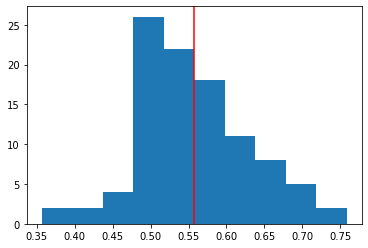

In [ ]:
print(f"Mean:{np.mean(accs_dev_LSTM)}, Min:{np.min(accs_dev_LSTM)}, Max:{np.max(accs_dev_LSTM)}")
print(f"50th percentile. {np.percentile(accs_dev_LSTM, 50)}")
plt.hist(accs_dev_LSTM)
plt.axvline(np.mean(accs_dev_LSTM), color='red')
plt.show()

Mean:0.5871604937687516, Min:0.4999999962747097, Max:0.6975308656692505


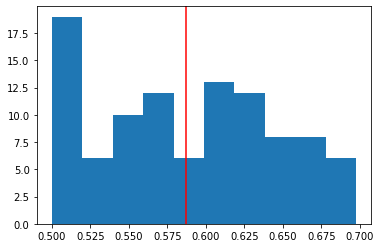

In [ ]:
print(f"Mean:{np.mean(accs_test_LSTM)}, Min:{np.min(accs_test_LSTM)}, Max:{np.max(accs_test_LSTM)}")
plt.hist(accs_test_LSTM)
plt.axvline(np.mean(accs_test_LSTM), color='red')
plt.show()

Mean:0.587606177565441, Min:0.0, Max:1.0


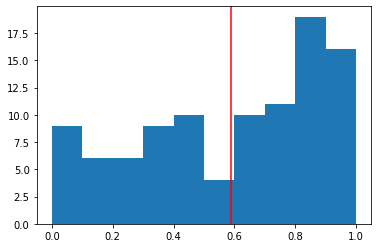

In [ ]:
print(f"Mean:{np.mean(fscore_eval_LSTM)}, Min:{np.min(fscore_eval_LSTM)}, Max:{np.max(fscore_eval_LSTM)}")
plt.hist(fscore_eval_LSTM)
plt.axvline(np.mean(fscore_eval_LSTM), color='red')
plt.show()